# Classical modeling using bayesian inference

In this notebook we will fit some basic time series model to our data. To keep the problem simple, we will initially put our focus on just one time series

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import matplotlib as mpl

import pystan
import arviz as az

## AR(p)

The process is written as

$$
y_t = \sum_{i=1}^p \psi_i y_{t-i} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$

Here our parameter vector is maden by $\underline \theta = [\psi_1, \ldots, \psi_p, \sigma^2]$. We assume the following conjugate prior

$$
\begin{align*}
\underline \psi &\sim \mathcal{N}_p(\underline \mu_0, \sigma^2 C_0) \\
\sigma^2 &\sim inv\Gamma\Biggl(\frac{n_0}{2}, \frac{n_0 \sigma_0^2}{2} \Biggr)
\end{align*}
$$

In [61]:
# load data as produced by DataCollection
fullData = pd.read_csv("../data/tsData.csv")
fullData["created_at"] = pd.to_datetime(fullData["created_at"])
fullData.set_index("created_at", inplace=True)

# set pot, and period of time where consider data
interestingPot = 1091
startDate      = "2020-09-01"
endDate        = fullData.index.max()


data = fullData.loc[fullData["pot_id"]==interestingPot][startDate:endDate]

# drop useless features in this analysis
data.drop(["latitude", "longitude", "weekend"], axis = 1, inplace = True)
data = data.dropna()
data.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,wind,rain
created_at,,,,,,,,,
2020-09-01 00:00:00,1091,3.22,3.50,4.68,4.80,12.65,68.01,1.50,0.00
2020-09-01 01:00:00,1091,4.48,5.00,6.03,6.15,11.92,70.00,1.30,0.00
2020-09-01 02:00:00,1091,8.12,8.00,11.32,11.56,10.62,70.00,0.80,0.00
2020-09-01 03:00:00,1091,6.41,6.00,7.53,7.60,10.28,70.00,0.50,0.00
2020-09-01 04:00:00,1091,6.56,6.00,7.92,8.00,10.03,70.00,0.10,0.00


In [52]:
# fit the model and run MCMC
model_code = '''
    data{
        int<lower=0> N;
        real y[N];
    }
    parameters {
        real phi1;
        real phi2;
        real<lower=0> sigma;
    } 
    model {
        sigma ~ inv_gamma(2,100);
        phi1  ~ normal(0,1);
        phi2  ~ normal(0,1);
        
        for (n in 3:N){
            y[n] ~ normal(phi1 * y[n-1] + phi2 * y[n-2] , sigma);
        }
    }
'''

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd6886fa70488dfb59f8c793caf98001 NOW.


In [65]:
MCMCdata = {'N': len(data["pm2p5SPS"].index),
            'y': data["pm2p5SPS"].values}

y = model.sampling(data=MCMCdata, iter = 10000).extract()

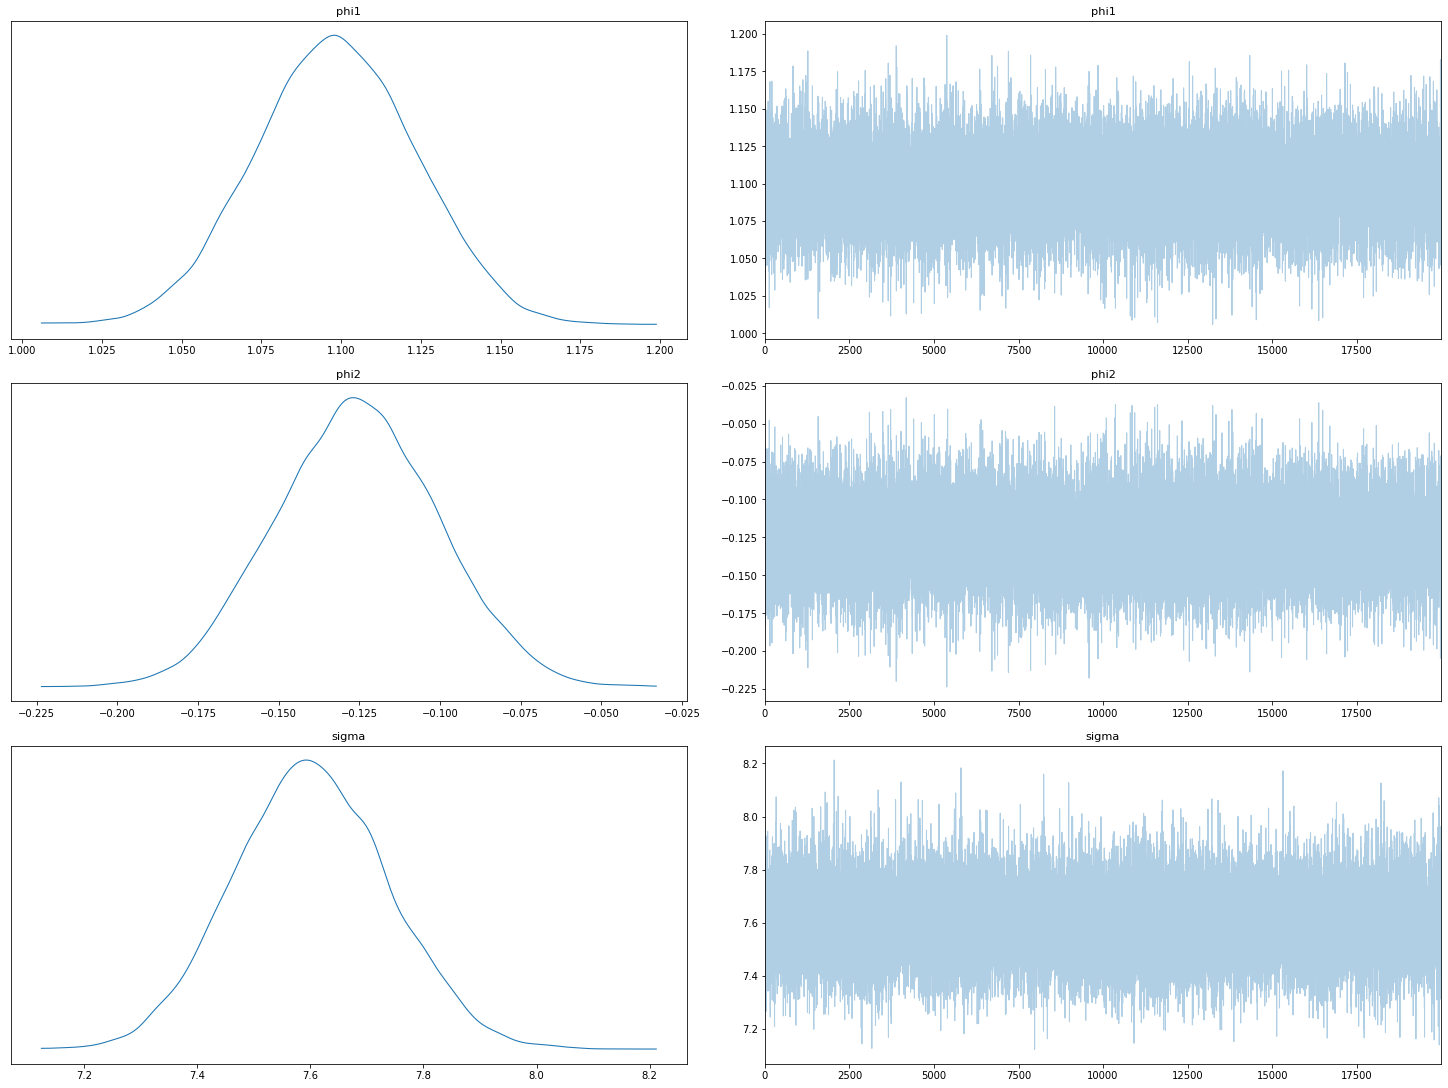

In [70]:
# plot the results
plotDict = {k : y[k] for k in ['phi1', 'phi2', 'sigma']}
az.plot_trace(plotDict)
plt.gcf().set_size_inches(20, 15)
plt.show()

In [27]:
def color_column(column, color, columnName):
    style = 'background-color:' + color
    return [style if column.name == columnName else "" for c in column]
    
dataColorato = (data.head(n=10)).style.apply(color_column, 
                                             color = "orange", 
                                             columnName = "pm1SPS", 
                                             axis=0)
dataColorato

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,wind,rain
created_at,,,,,,,,,
2020-09-01 00:00:00,1091,3.222500,3.500000,4.682500,4.797500,12.655000,68.010000,1.500000,0.000000
2020-09-01 01:00:00,1091,4.480000,5.000000,6.030000,6.150000,11.920000,70.000000,1.300000,0.000000
2020-09-01 02:00:00,1091,8.120000,8.000000,11.320000,11.560000,10.620000,70.000000,0.800000,0.000000
2020-09-01 03:00:00,1091,6.410000,6.000000,7.530000,7.600000,10.280000,70.000000,0.500000,0.000000
2020-09-01 04:00:00,1091,6.560000,6.000000,7.915000,8.000000,10.027500,70.000000,0.100000,0.000000
2020-09-01 05:00:00,1091,7.572500,7.500000,9.290000,9.402500,9.577500,70.000000,0.300000,0.000000
2020-09-01 06:00:00,1091,8.092500,7.250000,8.557500,8.557500,9.232500,70.000000,0.600000,0.000000
2020-09-01 07:00:00,1091,9.960000,10.000000,13.157500,13.392500,8.635000,70.000000,0.800000,0.000000
2020-09-01 08:00:00,1091,10.542500,9.750000,12.880000,13.035000,10.895000,70.000000,0.900000,0.000000
